# Approved and investigorial ligands (PKIDB) in KLIFS

Get a list of PKI ligands in KLIFS.
- Load all KLIFS ligands from KLIFS API
- Load all PKIDB ligands from file
- Merge KLIFS and PKIDB ligands on InChIKey

In [1]:
from datetime import datetime

from bravado.client import SwaggerClient
import pandas as pd
from rdkit.Chem import PandasTools

RDKit WARNING: [21:15:21] Enabling RDKit 2019.09.3 jupyter extensions


In [2]:
from pkidb_download import get_data_from_pkidb

## Load KLIFS ligands

In [3]:
KLIFS_API_DEFINITIONS = "http://klifs.vu-compmedchem.nl/swagger/swagger.json"
KLIFS_CLIENT = SwaggerClient.from_url(KLIFS_API_DEFINITIONS, config={'validate_responses': False})

In [4]:
def _all_ligands():
    
    ligands = KLIFS_CLIENT.Ligands.get_ligands_list().response().result
    ligands_list = [[i.InChIKey, i.Name, i['PDB-code'], i.ligand_ID] for i in ligands]
    ligands_df = pd.DataFrame(ligands_list, columns='InChIKey Name PDB-code ligand_ID'.split())
    
    return ligands_df

In [5]:
klifs_ligands = _all_ligands()
print(klifs_ligands.shape)
klifs_ligands.head(3)

(3324, 4)


,InChIKey,Name,PDB-code,ligand_ID
0,SAAYRHKJHDIDPH-UHFFFAOYSA-N,5-[(2-methyl-5-{[3-(trifluoromethyl)phenyl]car...,IHZ,1
1,CQZZZUNOWZUNNG-UHFFFAOYSA-N,"3-{2-[5-(difluoromethyl)-2H-thieno[3,2-c]pyraz...",477,2
2,JSHRNKDQLCOTRI-HNNXBMFYSA-N,"1-[(3S)-3-{[4-(morpholin-4-ylmethyl)-6-([1,3]t...",G6K,3


## Add PDB IDs (deposited in KLIFS) to KLIFS ligands

In [6]:
def _klifs_pdb_ids_per_ligand(ligand_id):
    """
    Get all KLIFS pdb IDs for a ligand by its KLIFS ligand ID.
    """
    
    structures = KLIFS_CLIENT.Ligands.get_ligands_list_structures(ligand_ID=ligand_id).response().result
    pdb_ids = [structure.pdb for structure in structures]
    
    return list(set(pdb_ids))

In [7]:
def _add_klifs_pdb_ids(klifs_ligands):
    """
    Add column for KLIFS PDB IDs which contain KLIFS ligands.
    """
    
    klifs_ligands['klifs_pdb_ids'] = klifs_ligands.ligand_ID.apply(lambda x: _klifs_pdb_ids_per_ligand([str(x)]))
    
    return klifs_ligands

In [8]:
# This step takes a few minitues
klifs_ligands = _add_klifs_pdb_ids(klifs_ligands)

In [9]:
klifs_ligands.head()

,InChIKey,Name,PDB-code,ligand_ID,klifs_pdb_ids
0,SAAYRHKJHDIDPH-UHFFFAOYSA-N,5-[(2-methyl-5-{[3-(trifluoromethyl)phenyl]car...,IHZ,1,[3dko]
1,CQZZZUNOWZUNNG-UHFFFAOYSA-N,"3-{2-[5-(difluoromethyl)-2H-thieno[3,2-c]pyraz...",477,2,"[3v8t, 3vf9]"
2,JSHRNKDQLCOTRI-HNNXBMFYSA-N,"1-[(3S)-3-{[4-(morpholin-4-ylmethyl)-6-([1,3]t...",G6K,3,[4kio]
3,LZANMDGKZJPQIB-HNNXBMFYSA-N,"1-[(3S)-3-{[4-(morpholin-4-ylmethyl)-6-([1,3]t...",G5K,4,[4kio]
4,WINHZLLDWRZWRT-ATVHPVEESA-N,N-[2-(diethylamino)ethyl]-5-[(Z)-(5-fluoro-2-o...,B49,5,"[3ti1, 3miy, 4qmz, 3g0e, 4ks8, 3g0f, 2y7j, 4ag..."


## Load PKIDB ligands

In [10]:
pkidb_ligands = get_data_from_pkidb()
print(pkidb_ligands.shape)
pkidb_ligands.head(3)

(218, 25)


,INN_Name,BrandName,Phase,Applicants,LigID,pdbID,Type,RoF,MW,LogP,...,Targets,Kinase_families,First_Approval,SC_Patent,Chirality,Synonyms,FDA_approved,Melting_points_C,Canonical_Smiles,InChIKey
0,Leniolisib,None,0.0,Novartis,9NQ,[5o83],NaN,0,450.2,2.9,...,None,None,None,None,Single Stereoisomer,"[CDZ173-NX, Leniolisib]",None,None,CCC(=O)N1CC[C@@H](C1)Nc2c3c(ncn2)CCN(C3)c4cc(c...,MWKYMZXCGYXLPL-ZDUSSCGKSA-N
1,Nemiralisib,None,0.0,GlaxosmithKline,VVX,[5ae8],NaN,0,440.2,4.9,...,None,None,None,None,Single Stereoisomer,"[GSK2269557A, GSK-2269557, Nemiralisib]",None,None,CC(C)N1CCN(CC1)Cc2cnc(o2)c3cc(cc4c3cn[nH]4)c5c...,MCIDWGZGWVSZMK-UHFFFAOYSA-N
2,Oclacitinib,None,0.0,Pfizer,None,None,NaN,0,337.2,1.5,...,"[JAK1, JAK2, JAK3]",[Tyr],None,None,Single Stereoisomer,"[Oclacitinib, JAKI, PF-03394197]",None,None,CNS(=O)(=O)C[C@H]1CC[C@@H](CC1)N(c2ncnc3c2cc[n...,HJWLJNBZVZDLAQ-HAQNSBGRSA-N


## Check for PKIDB ligands in KLIFS

In [11]:
def pkidb_ligands_in_klifs(klifs_ligands, pkidb_ligands):
    """
    Get all KLIFS ligands that are in PKIDB.
    """
    
    klifs_pki = pd.concat(
        [pkidb_ligands.set_index('InChIKey'), klifs_ligands.set_index('InChIKey')], 
        axis=1, 
        join='inner', 
        ignore_index=False, 
        keys=None,
        levels=None, 
        names=None, 
        verify_integrity=False, 
        copy=True
    )
    
    klifs_pki.reset_index(inplace=True)
    
    PandasTools.AddMoleculeColumnToFrame(klifs_pki, smilesCol='Canonical_Smiles')
    
    return klifs_pki

(99, 30)


,InChIKey,INN_Name,BrandName,Phase,Applicants,LigID,pdbID,Type,RoF,MW,...,Chirality,Synonyms,FDA_approved,Melting_points_C,Canonical_Smiles,Name,PDB-code,ligand_ID,klifs_pdb_ids,ROMol
0,MWKYMZXCGYXLPL-ZDUSSCGKSA-N,Leniolisib,None,0.0,Novartis,9NQ,[5o83],NaN,0,450.2,...,Single Stereoisomer,"[CDZ173-NX, Leniolisib]",None,None,CCC(=O)N1CC[C@@H](C1)Nc2c3c(ncn2)CCN(C3)c4cc(c...,Leniolisib,9NQ,2890,[5o83],
1,MCIDWGZGWVSZMK-UHFFFAOYSA-N,Nemiralisib,None,0.0,GlaxosmithKline,VVX,[5ae8],NaN,0,440.2,...,Single Stereoisomer,"[GSK2269557A, GSK-2269557, Nemiralisib]",None,None,CC(C)N1CCN(CC1)Cc2cnc(o2)c3cc(cc4c3cn[nH]4)c5c...,6-(1H-Indol-4-yl)-4-(5-{[4-(1-methylethyl)-1-p...,VVX,2646,[5ae8],
2,RZUOCXOYPYGSKL-GOSISDBHSA-N,Ravoxertinib,None,1.0,Genentech,6QB,"[5k4i, 5k4j, 6oph]",NaN,0,440.1,...,Single Stereoisomer,"[Ravoxertinib, RG-7842, GDC-0994]",None,None,Cn1c(ccn1)Nc2nccc(n2)c3ccn(c(=O)c3)[C@H](CO)c4...,1-[(1~{S})-1-(4-chloranyl-3-fluoranyl-phenyl)-...,6QB,2137,"[6oph, 5k4j, 5k4i]",

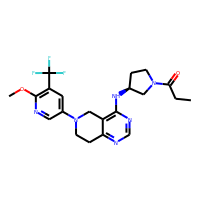
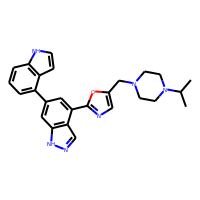
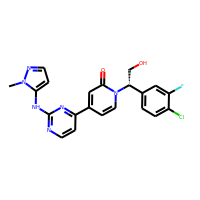

In [12]:
klifs_pki = pkidb_ligands_in_klifs(klifs_ligands, pkidb_ligands)
print(klifs_pki.shape)
klifs_pki.head(3)

In [13]:
klifs_pki.to_csv(f'results/klifs_pki_{datetime.now().strftime("%Y%m%d")}.csv', index_label=None)

## Look into PKI in KLIFS (to be continued)

In [14]:
klifs_pki.groupby('Phase').size()

Phase
0.0     2
1.0     2
2.0    32
3.0    23
4.0    40
dtype: int64